In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import pathlib
#import tifffile
import h5py

import napari
from napari.utils.notebook_display import nbscreenshot

import seaborn as sns

from dask_image.imread import imread
import dask.array as da

from scipy import ndimage as ndi

import skimage.segmentation as segmentation 
import skimage.filters as filters

#from skimage.feature import peak_local_max
from skimage.measure import label, regionprops, regionprops_table
from skimage import morphology

# Postprocessing Segmentation
Ilastik outputs a probability mask that assigns a probability for each pixel that it either belongs to foreground (cell) or background.
We now need to convert this to a proper segmentation.

> **Exercise**  
>  
> Think about the steps needed to convert a probability map to a segmentation.

## Import and visualize data
First we import visualize the raw data using Napari.

In [25]:
#Set the path to the folder that contains project data
#pathlib.Path.home() return the location of your home folder in a platform independent way. 
root = pathlib.Path(pathlib.Path.home(), 
                    'I2ICourse/Project2A/ProcessedData/')

image_name = 'pos0_preproc-rg.tif' #set name of image
segment_name = 'pos0_preproc-rg_Probabilities.h5' #set name of segmented data
n_channel = 2 #set number of color channels in image
fg_idx = 0 #set index of foreground label used in Ilastik

im_path = root / image_name 
print('path to image: ', im_path)

path to image:  /Users/simonvanvliet/I2ICourse/Project2A/ProcessedData/pos0_preproc-rg.tif


Time-lapse images can be big, and can easily overload your memory. To make sure this does not happen, you can use "out of memory" computation, where only the data that is directly needed is loaded into memory (e.g. the current time point). This is slower then loading the full dataset into memory, but it scales well when data gets too big to do that. Out-of-memory computation is quite easy with the use of [Dask image](https://image.dask.org/en/latest/). We will use this below.

Don't worry about the technical details, though if you are curious we provide some optional 'Technical Notes' below: 

In [18]:
# you can use tifffile.imread to read complete image stack into memory.
#im_stack = tifffile.imread(im_path) #load image into memory

# or dask_image imread to use out of memory processing
im_stack = imread(im_path) #load image with dask-image for out of memory processing 

# dask_image imread creates a 3D stack, where both color channels are interweaved
# to separate them we need to reshape to 4D stack
if n_channel>1: 
    newshape = (int(im_stack.shape[0]/n_channel), n_channel, *im_stack.shape[1:])
    im_stack = im_stack.reshape(newshape)


To visualize the data we will use [Napari](https://napari.org), that allows for interactive image visualisation. 
We will first load the raw data. Use the slider at the bottom to scroll trough time. 

*(Technical note: Napari and Dask work very well together, every time you move the time slider, Dask loads the corresponding image into memory.)*

In [28]:
#setup napari viewer, with 2 channel image
viewer = napari.view_image(im_stack,
            channel_axis=1,
            name=["red", "green"],
            colormap=["yellow", "blue"],)
napari.run()

Next we load the segmentation data exported by Ilastik.

In [26]:
seg_path = root / segment_name #path to Ilastik output
seg_data = h5py.File(seg_path, 'r')
print('keys = ', list(seg_data.keys()))

keys =  ['exported_data']


`h5py.File=()` loads a dictionary, which contains a single key `exported_data`.  
This contains the Ilastik segmentation probability output as an array of shape (t,c,y,x).  
We only need the probability that a pixel belongs to the foreground class (= cells) and add this layer to the viewer.

In [47]:
#we again use Dask to load the data out of memory
#technical comment: we set chunk size to be equal to the size of single frame. 
chuck_size = (1, *im_stack.shape[-2:]) if n_channel==1 else (1, n_channel, *im_stack.shape[-2:])
seg_cell = da.from_array(seg_data['exported_data'], chunks=chuck_size)

#we get a segmentation probability for both labels (cells and BG) but only need the one for the cells, so we extract the correct dimension:
seg_cell = seg_cell[:,fg_idx,:,:]

Now we add the probability layer to the Napari Viewer.

You can change the opacity and layer order to improve visualization.

In [48]:
#add probability layer to Napari Viewer
prop_layer = viewer.add_image(seg_cell, name='probability',colormap='gray')

> **Exercise** 
>   
> Check the segmentation quality. How well did it work? Are there frames with big problems?
>   
> If needed, you can go back to Ilastik and add extra training points in problem areas (check with Tutor).

## Filtering data
As a first step probability maps are often processed using a Gaussian blur filter using a small (~1 pixel) size, to ensure that the probability maps are locally smooth. We will use scikit image [`filters.gaussion`](https://scikit-image.org/docs/stable/api/skimage.filters.html) to do this. 

*(Technical note: scikit images does not automatically play nice with Dask's out of memory processing, instead we need to manually specify that we want to run `filters.gaussion` on each chunk (i.e. each frame) of our `seg_cell` image stack. This we can do using the Dask Image [`map_blocks()` function](https://docs.dask.org/en/latest/generated/dask.array.map_blocks.html))*.

*The usage is pretty straightforward, if normally you would use: `name_of_function_to_apply(normal_array, other_function_arguments)` you can now use: `da.map_blocks(name_of_function_to_apply, dask_array, other_function_arguments)`*

In [66]:
sigma = 1 #size of Gaussion kernel to use 

#this is how you normally use scikit filters.gaussian
#seg_cell_sm = filters.gaussian(seg_cell, sigma, channel_axis=0) 

#this is how we do it using Dask:
seg_cell_sm = da.map_blocks(filters.gaussian, seg_cell, sigma, channel_axis=0)

#add to viewer
prop_layer_sm = viewer.add_image(seg_cell_sm, name='probability smoothed',colormap='gray')


## Threshold data

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to convert continues probability maps into binary label images. It is a first step in segmenting objects. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker.

There are automatic methods to calculate a threshold, e.g. Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. However, often a manually chosen thresholds works best, and we will use that here.  

In [67]:
#create array with all threshold values to rry, here we use 0,0.01,0.02,...,1
thresholds_to_try = np.linspace(0,1,101)

#apply treshold
all_thresholds = [seg_cell_sm>t for t in thresholds_to_try]

#convert to stack
threshold_stack = da.stack(all_thresholds, axis=0)

#add to viewer
mask_layer_int = viewer.add_image(threshold_stack, name='binary mask int',colormap='gray')

In the Napari viewer you will now have a new layer `binary mask int`, which shows you the result of the interactive thresholding, you can change the threshold value by moving the new slider (channel 0).

> **Exercise** 
>  
> Move the slider to find a good threshold value. How does it compare to the one calculated by the algorithms above? 
> 
> Hint: the slider position shows the index in the `thresholds_to_try`

Note: if at any time you want to store the current view shown in the Napari viewer, then you can use `nbscreenshot(viewer)`.

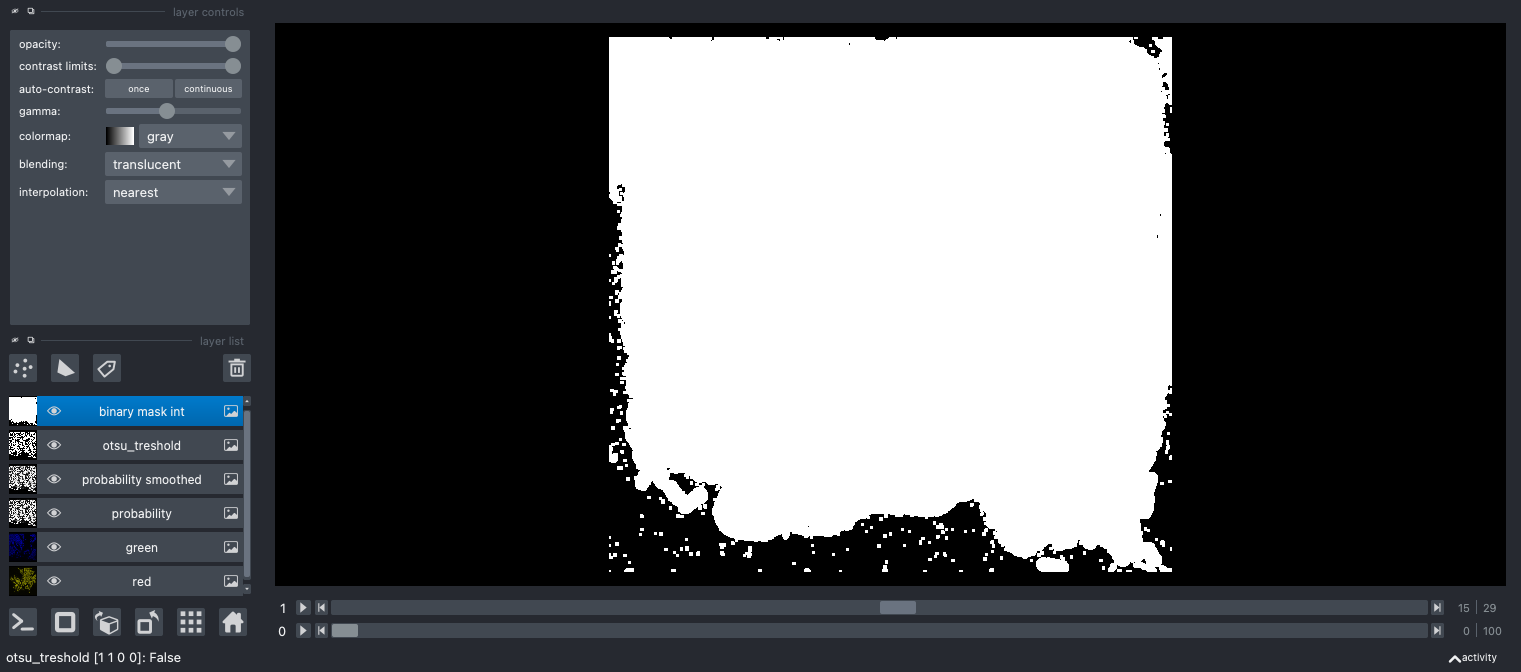

In [9]:
nbscreenshot(viewer)

> **Exercise** 
> 
> Now it is time to choose a final threshold value. Enter the value you have chosen below.

In [68]:
#choose your favorite method or enter a manually chosen value
final_threshold = 0.66

#threshold and add to viewer
bin_mask = seg_cell_sm > final_threshold
mask_layer_final = viewer.add_image(bin_mask, name='final binary mask',colormap='gray')

We can now remove the interactive threshold layer from the viewer.

In [69]:
viewer.layers.remove("binary mask int")

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a size parameter, which is the minimum size (in pixels) of accepted holes or objects.


> **Exercise**
>
> Try finding good values for `max_hole_size` and `min_cell_size`, by changing the parameters below.


*(Technical note `skimage.morphology` only works on 2D/3D image data, not on time stacks, we thus have to apply it to each frame separately, luckily `da.map_blocks()` can take care of that for us)*

In [74]:
max_hole_size = 40 # maximum area of holes that will be filled (in pixels)
min_cell_size = 150 # minimum area of objects to keep (in pixels)

holes_removed = da.map_blocks(morphology.remove_small_holes, bin_mask, max_hole_size)
bin_mask_clean = da.map_blocks(morphology.remove_small_objects, holes_removed, min_cell_size)

mask_layer_clean = viewer.add_image(bin_mask_clean, name='binary mask cleaned',colormap='gray')

## Segmentation

### Create Label Image

Now we are ready to label the connected components of this image. This means that each object will be assigned a unique number. For this we can use the [`skimage.measure.labels()`](https://scikit-image.org/docs/dev/api/skimage.measure.html) function.
To add labels to Napari, we can use the `add_label()` function.

You can change the colors assigned to cells, using the shuffle button in upper left corner. 

In [87]:
#again we will need to loop over the time using map_blocks
label_im = da.map_blocks(label, bin_mask_clean)
label_layer = viewer.add_labels(label_im, opacity=0.5)

> **Exercise**
> 
> Inspect the segmentation. Do you find any problems? Think about what we need to do next.

### Watershed to separate merged cells

We can see that tightly packed cells connected in the binary image are assigned the same label.

A better segmentation would assign different labels to different cells. 

Typically we use [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) for this purpose. This requires two steps: 1) using a so-called [distance transform](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html) we  calculate the distance of each pixel to the object boundary 2) we need to find center points (called *markers*) for each object. We place *markers* at the centre of each object, and these labels are expanded until they meet an edge or an adjacent marker.

The trick, then, is how to find these markers. For spherical cells, there is a commonly used strategy that works quite well: we can simply find the local maxima of the distance transform (we provide the code for this below for reference).

For rod shape cells, this works quite badly. hough. Another way to find cell centers is by using a very high threshold for the probability map to find regions where we are very sure that there are cells. Then we can use these regions as markers for the watershed.

In [100]:
#set threshold to use to find cell centers
center_threshold = 0.95

center_seg = seg_cell_sm > center_threshold
center_markers = da.map_blocks(label, center_seg)
    
centre_layer = viewer.add_labels(center_markers, name='cell centre areas')   

> **Exercise**
> 
> Find a good value to use for `center_threshold` such that nearby cells have different center markers (without chopping cells into parts). Spend max 5 min on this! 

Once we have the center points we can further segment the image by using the watershed, we calculate the distance using [scipy.ndimage.morphology.distance_transform_edt](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html) and then apply the watershed using [`skimage.segmentation.watershed`](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed):

In [121]:
#we need a wrapper function to tranform named arguments into positional arguments to make things work with Dask
def watershed(dist, markers, mask):
    return segmentation.watershed(-dist, markers=markers, mask=mask)    

In [124]:
#calculate distance to edge of mask
dist_transform = da.map_blocks(ndi.distance_transform_edt, bin_mask_clean)   

#run watershed
label_sep = da.map_blocks(watershed, -dist_transform, center_markers, bin_mask_clean, chunks=(1,*bin_mask_clean.shape[-2:]))

#add to Napari
watershed_layer = viewer.add_labels(label_sep, name='after watershed')   

The watershed should have cut clusters of cells apart, improving the segmentation by separating nearby cells.

However, you might also have seen some cells that were cut but should not have. There are several things you could do here to improve things

- Improve segmentation
  - The better quality the input data has, the easier and better the post-processing will be 
  - In many cases the fastest solution will be to return to Ilastik and add some training points in problem regions
- Use 3 classes to segment your image (cell centre / cell edge / background)
  - You can then calculate distance transform on cell edge data
  - More over you can use `skimage.future.graph.rag.rag_boundary` and `skimage.future.graph.merge_hierarchical()` to merge objects back together 

For time reasons we will skip these steps now, but we can come back to them at the end of the course if time allows it. 

*Aside: Code to find markers for watershed algorithm for spherical cells*

```python
#calculate distance to edge of mask
dist_transform = da.map_blocks(ndi.distance_transform_edt, bin_mask_clean)   

#add to Napari 
dist_layer = viewer.add_image(dist_transform, name='distance transform',colormap='viridis')  

#min distance between maxima, adjust this value to slightly less than 2x the radius of the smallest cells.
min_distance = 10


#initialize empty array of right size
markers_list = np.empty((3,0))

#find maxima in distance transform
for t, dist_map in enumerate(dist_transform):
    #dist_map = filters.gaussian(dist_map, 2) 
    peak_idx = peak_local_max(dist_map.compute(), min_distance=min_distance)
    peak_idx_3d = np.insert(peak_idx.T,0,t,axis=0)
    markers_list = np.concatenate((markers_list,peak_idx_3d),axis=1)
    
#add to Napari Viewer
point_layer = viewer.add_points(
    np.transpose(markers_list),
    name='center points',
    size=4,
    n_dimensional=False)
```

## Making measurements

Once we have defined our objects, we can make measurements on them using `skimage.measure.regionprops` and the new `skimage.measure.regionprops_table`. These measurements include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [21]:
interior_labels = np.empty_like(label_sep) #initialize empty array of right size for ou
for t, label_im in enumerate(label_sep):
    interior_labels[t, :, :] = segmentation.clear_border(label_im)
    
int_lab = viewer.add_labels(interior_labels)

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. Note that color axis needs to be at the end!

In [22]:
reg_props = [0]

for label_im, image in zip(label_sep, im_stack):
    #region props need color channel to be at end
    image = np.moveaxis(image, 0, -1)
    reg_props.append(regionprops(label_im, intensity_image=image))
    
    
print(len(reg_props))
print(len(reg_props[0]))
print(reg_props[0][0])
reg_props[0][0].area   

31


TypeError: object of type 'int' has no len()

Above we made a list containing the region properties for each time point.

You can extract the properties for each time point using `reg_props[t]`. This returns another list containing all cells at that time point. To see the properties of a single cell we can use `rep_props[t][c]`. This return a skimage region properties object, which is basically a dictionary. We can thus extract a property using `rep_props[t][c].[property_name]`.

> **Exercise** 
> 
> Look at the scikit-image documentation for [`regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops) to see what kind of properties are extracted

Note: scikit-image 0.18 adds support for [passing custom functions](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for region properties as `extra_properties`.

We can now look at some cell properties:

[158.70634921 770.61375661]


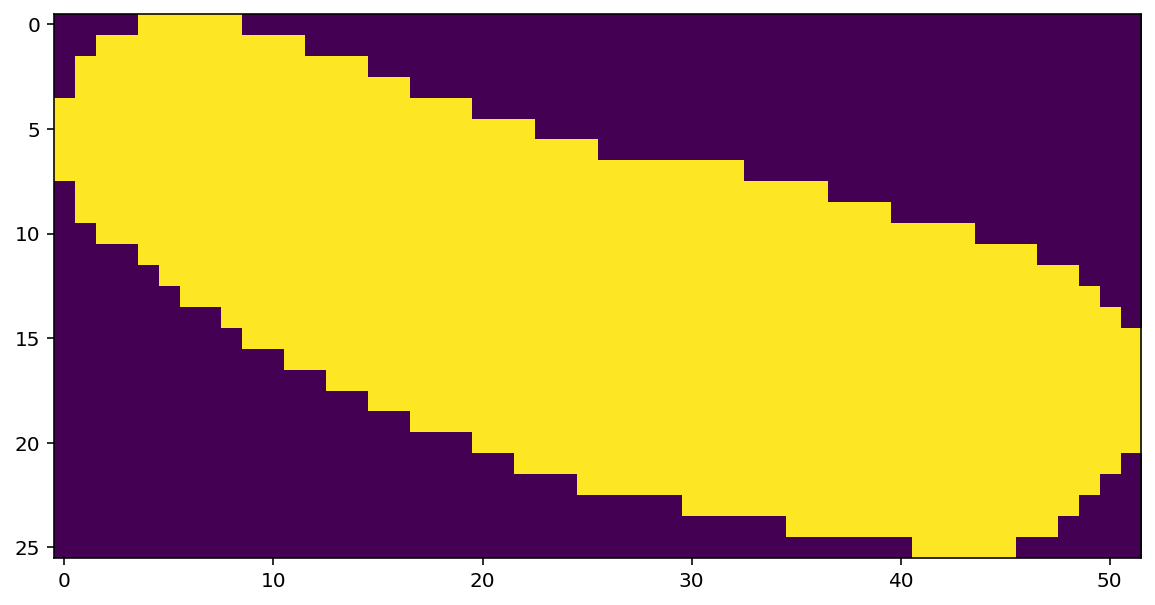

In [23]:
#explore some cell properties
print(reg_props[1][2].intensity_mean)
fig, axs = plt.subplots(figsize=(10,5))
axs.imshow(reg_props[1][2].image.T)

`regionprops` returns a huge amount of info, but navigating it is a bit cumbersome. 

Instead you can use [`regionprops_table`](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops), which returns a dictionary of columns compatible with creating a pandas dataframe of properties of the data.

Here we will first look at a single frame:

In [24]:
label_im = label_sep[0,:,:]    
image = np.moveaxis(im_stack[0,:,:], 0, -1)    
    
info_table = pd.DataFrame(
        regionprops_table(
        label_im,
        intensity_image=image,
        properties=['label', 'area', 'centroid', 
                    'axis_major_length', 'axis_minor_length',
                    'mean_intensity'] 
    )
).set_index('label')

With `head()` we can have a look at the Panda's data frame (similar to R data frame or Matlab structure)and with `columns` we can get info on the column (= variable name).

In [26]:
print(info_table.columns)
info_table.head()


Index(['area', 'centroid-0', 'centroid-1', 'axis_major_length',
       'axis_minor_length', 'mean_intensity-0', 'mean_intensity-1'],
      dtype='object')


,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1
label,,,,,,,
1,950,73.262105,1420.313684,78.168638,16.040507,151.365263,1226.183158
2,859,64.358556,1461.376019,76.139029,14.897100,138.108265,903.824214
3,756,85.839947,978.055556,57.380266,17.228570,158.706349,770.613757
4,688,87.027616,1401.511628,62.098941,14.490098,173.408430,1072.390988
5,1740,87.659195,1121.195402,164.980811,17.285783,970.826437,158.549425


Just as in R we can add new columns, for example we could calculate the aspect ratio, or add a constant value to e.g. indicate the frame nr.:

In [27]:
info_table["aspect_ratio"] = info_table['axis_major_length']/info_table['axis_minor_length']
info_table["frame"] = 0
info_table.head()

,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,aspect_ratio,frame
label,,,,,,,,,
1,950,73.262105,1420.313684,78.168638,16.040507,151.365263,1226.183158,4.873203,0
2,859,64.358556,1461.376019,76.139029,14.897100,138.108265,903.824214,5.110997,0
3,756,85.839947,978.055556,57.380266,17.228570,158.706349,770.613757,3.330530,0
4,688,87.027616,1401.511628,62.098941,14.490098,173.408430,1072.390988,4.285612,0
5,1740,87.659195,1121.195402,164.980811,17.285783,970.826437,158.549425,9.544307,0


So far we only analyzed a single frame, now let's combine them all. To do this it is helpful to define a function that processes a single time point and than call this for each time point. We the use `pandas.concat` to combine all time points into a single data frame.

In [28]:
  
def extract_prop_slice(t, label_im, image):
    #region props need color channel to be at end
    image = np.moveaxis(image, 0, -1)

    df = pd.DataFrame(
        regionprops_table(
        label_im,
        intensity_image=image,
        properties=['label', 'area', 'centroid', 
                    'axis_major_length', 'axis_minor_length',
                    'mean_intensity'] 
        )
    )
    #add the time index
    df["frame"] = t
    return df

#here we call the function for each time point.    
df_list = [extract_prop_slice(t, label, image) for t, (label, image) in enumerate(zip(label_sep, im_stack))]
info_table_all = pd.concat(df_list)
info_table_all.head()


,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame
0,1,950,73.262105,1420.313684,78.168638,16.040507,151.365263,1226.183158,0
1,2,859,64.358556,1461.376019,76.139029,14.897100,138.108265,903.824214,0
2,3,756,85.839947,978.055556,57.380266,17.228570,158.706349,770.613757,0
3,4,688,87.027616,1401.511628,62.098941,14.490098,173.408430,1072.390988,0
4,5,1740,87.659195,1121.195402,164.980811,17.285783,970.826437,158.549425,0


Now let's analyze some data. We will first look at how the number of cells changes over time, and plot using the Pandas build in plot function (based on Matplotlib)

<AxesSubplot:xlabel='frame', ylabel='# of cells'>

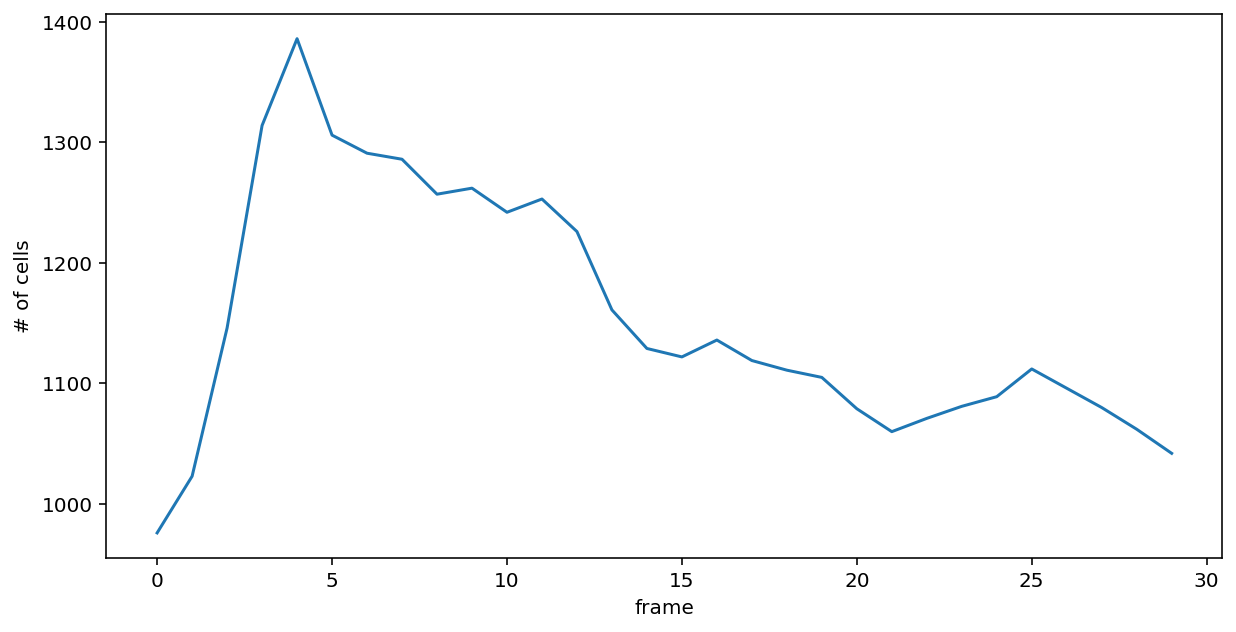

In [29]:
cell_num_t = info_table_all.groupby('frame').size()
cell_num_t.plot(xlabel='frame',ylabel='# of cells',figsize=(10,5))

Next let's calculate some average properties and see how they change over time, and we will plot the results with [Matplotlib](https://matplotlib.org/stable/index.html)

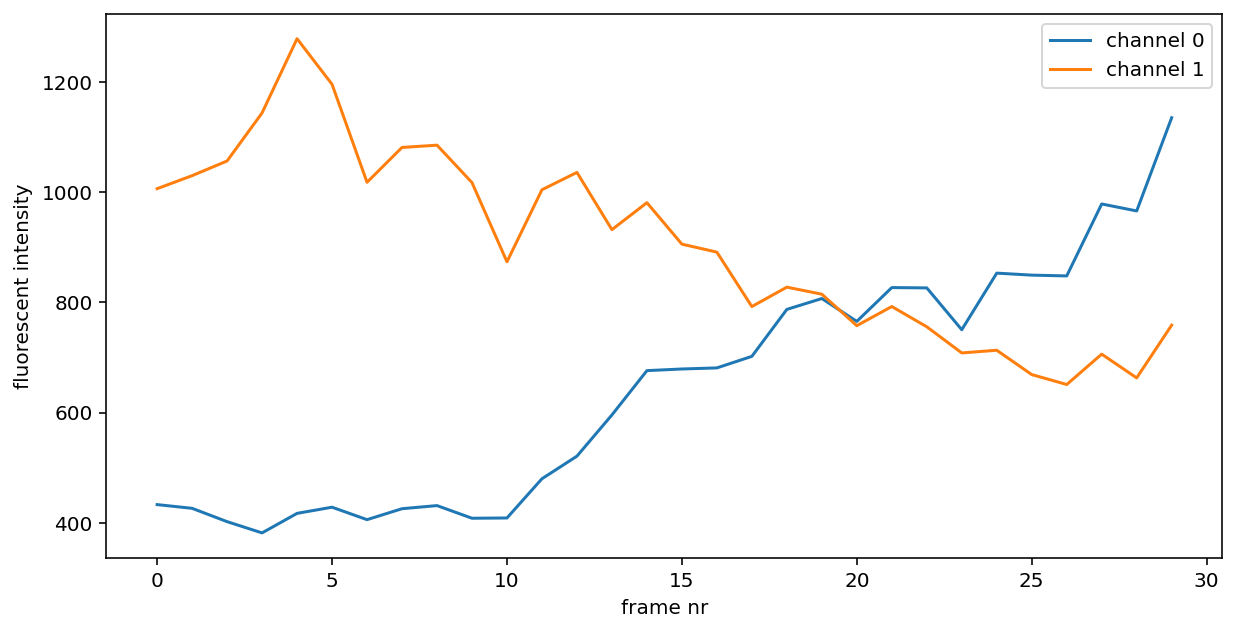

In [30]:
av_prop = info_table_all.groupby('frame').mean()
av_prop['frame'] = av_prop.index
av_prop.head()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(av_prop['frame'],av_prop['mean_intensity-0'],label='channel 0')
ax.plot(av_prop['frame'],av_prop['mean_intensity-1'],label='channel 1')
ax.set_xlabel('frame nr')
ax.set_ylabel('fluorescent intensity')
ax.legend()

For a more R-like experience with plotting, you can use [seaborn](https://seaborn.pydata.org/index.html):

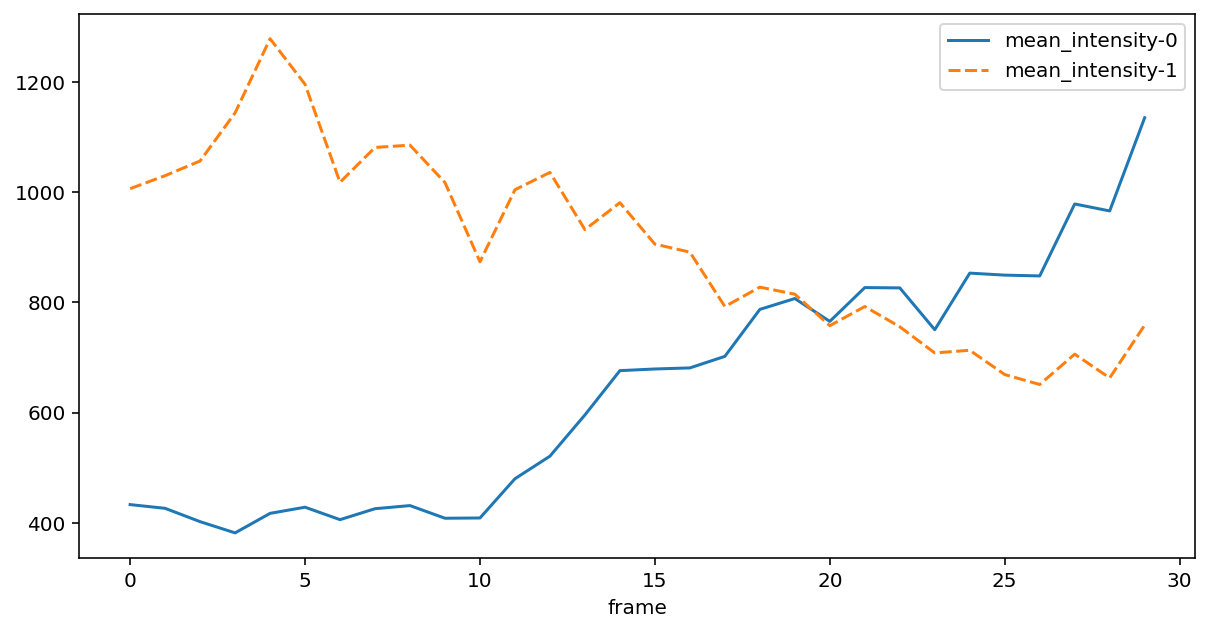

In [31]:
av_fluor = av_prop[["mean_intensity-0", "mean_intensity-1"]] 
sns.lineplot(data=av_fluor);

Similarly we can look at distributions and scatter plots:

<AxesSubplot:xlabel='mean_intensity-0', ylabel='mean_intensity-1'>

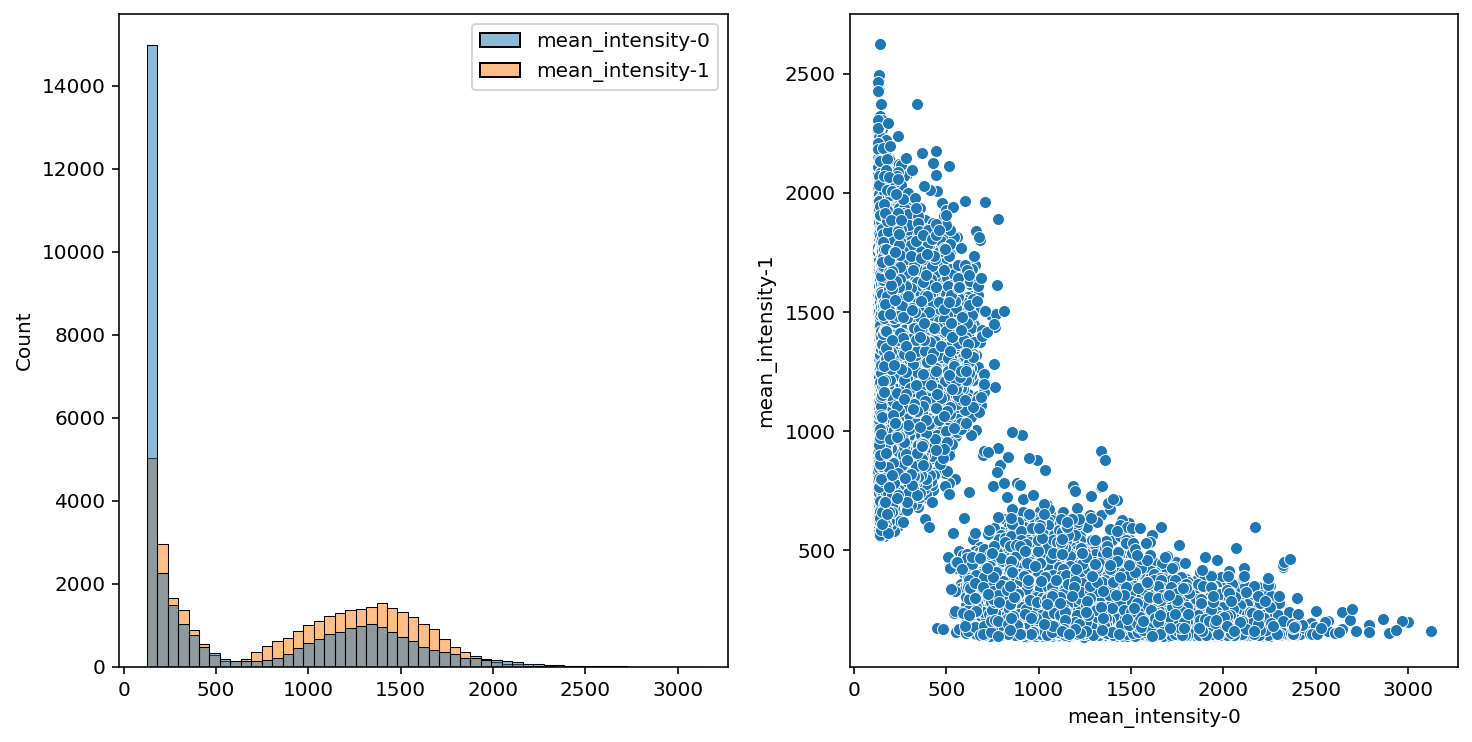

In [32]:
all_fluor = info_table_all[["mean_intensity-0", "mean_intensity-1"]] #create dataframe with only fluorescent values
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(ax=axs[0], data=all_fluor)
sns.scatterplot(ax=axs[1], data=all_fluor, x="mean_intensity-0", y="mean_intensity-1")

> ## Exercise
> We are interested in the dynamics of the community, and would like to know how the fraction of red cells changes over time. Try to come up with a way to calculate this.
> 
> Hints:
> - Think about how you can tell red and green cells apart in a reliable way
> - Classify cells as either red or green
> - Calculate the fraction of red cells over time

In [29]:
#enter code here

### Solution 1
To see the solution, uncomment (remove `#`) the `load` line below and run the cell twice (first time will load the code second time will run it)

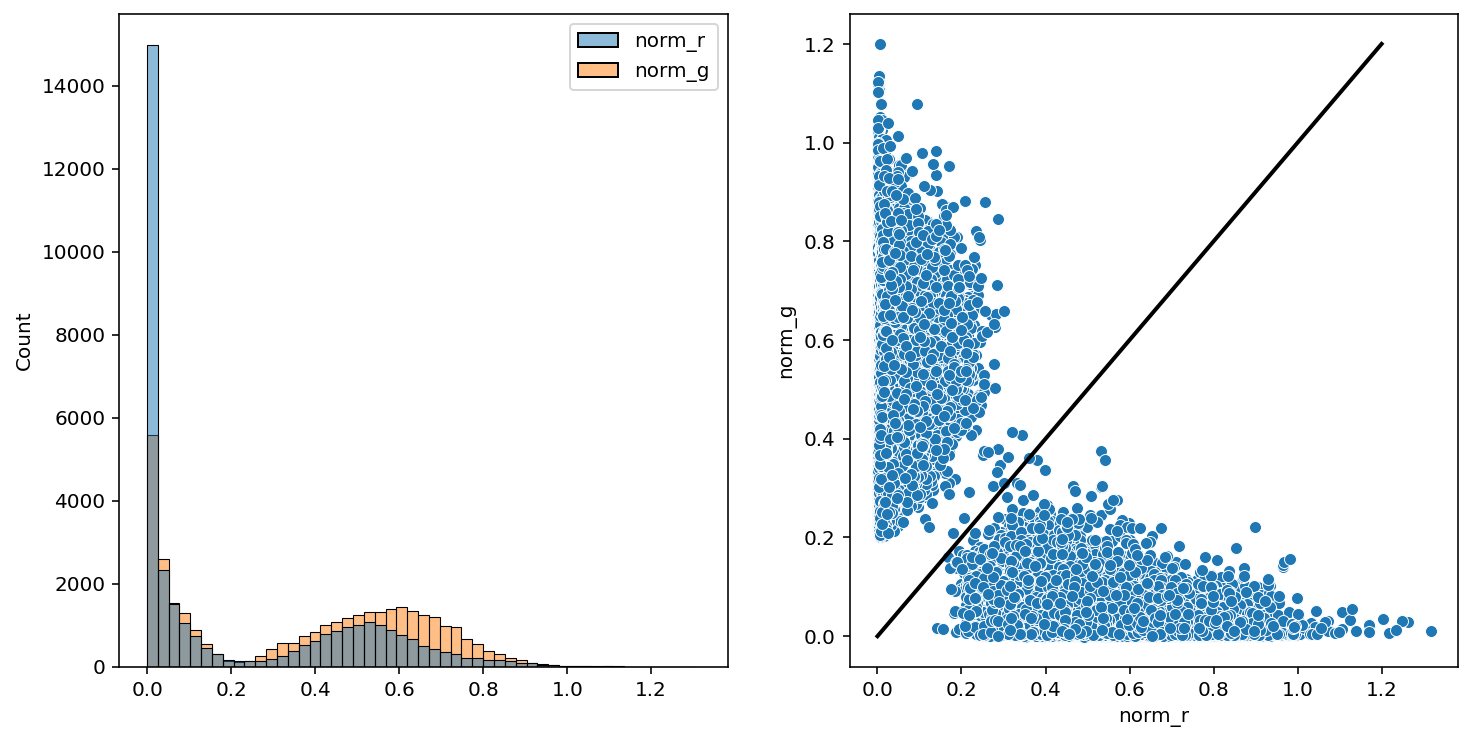

<AxesSubplot:xlabel='frame'>

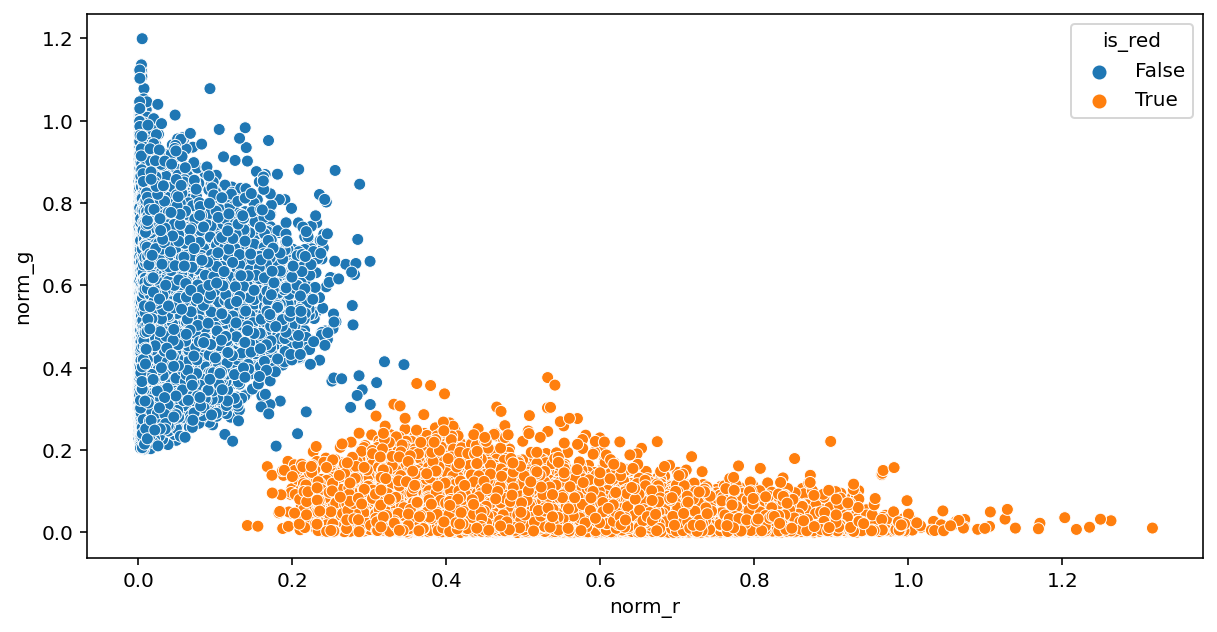

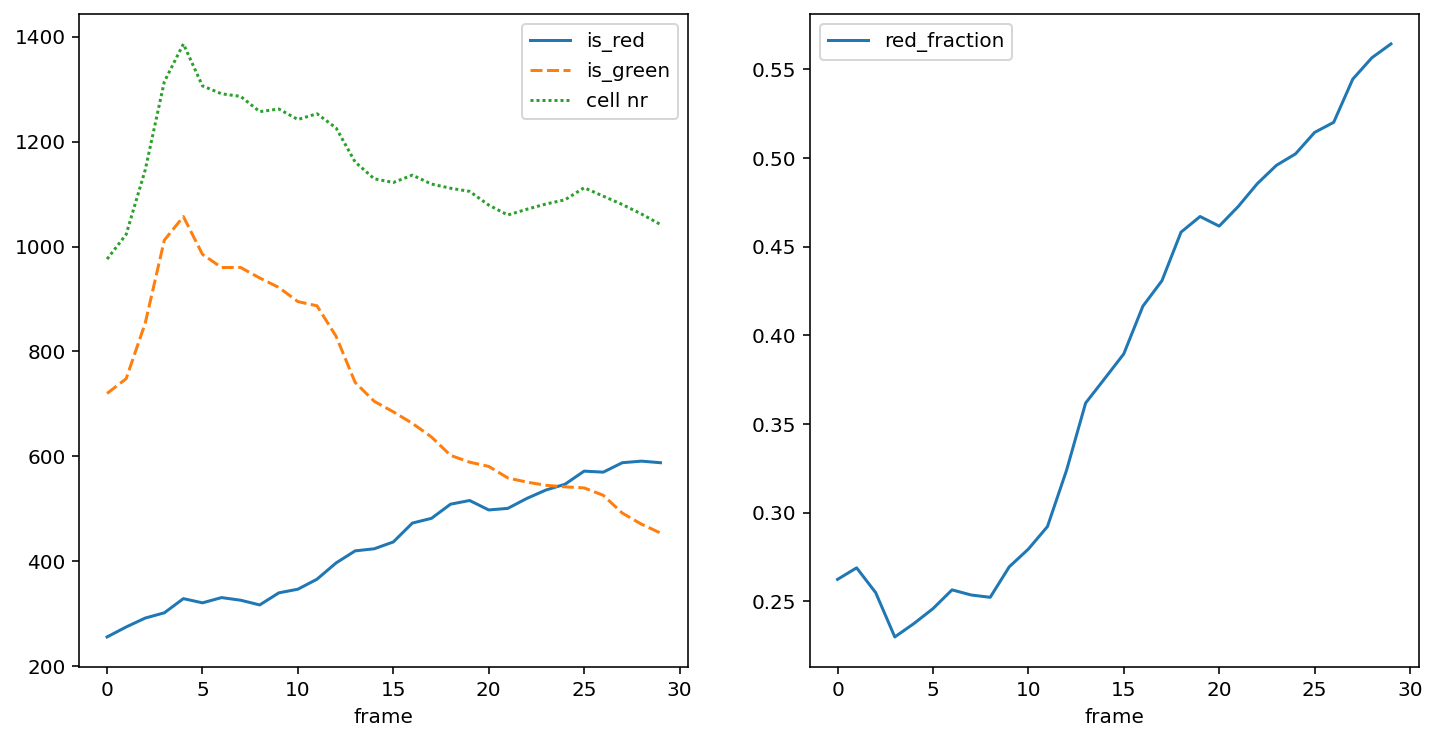

In [34]:
# %load ../Solutions/p0_classify_sol1.py
#Use normalization and fluorescent ratio
def norm_data(data, clip=[1E-3, 0.999], bounded=False):
    lims = np.quantile(data, clip)
    
    data_clipped = (data - lims[0]) / (lims[1] - lims[0])
        
    if bounded:
        data_clipped[data_clipped<0] = 0
        data_clipped[data_clipped>1] = 1
                
    return data_clipped
    
norm_red = norm_data(info_table_all["mean_intensity-0"])
norm_green = norm_data(info_table_all["mean_intensity-1"])
norm_fluor = pd.concat([norm_red,norm_green], keys=['norm_r','norm_g'], axis=1) 

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(ax=axs[0], data=norm_fluor)
sns.scatterplot(ax=axs[1], data=norm_fluor, x="norm_r", y="norm_g")

axs[1].plot([0, 1.2], [0, 1.2], linewidth=2, color='k')
plt.show()

norm_fluor['is_red'] = norm_red > norm_green
norm_fluor['is_green'] = norm_red <= norm_green
norm_fluor['cell nr'] = 1
norm_fluor['frame'] = info_table_all['frame'] 

sns.scatterplot(x=norm_fluor['norm_r'], y=norm_fluor['norm_g'], hue=norm_fluor['is_red'])


cell_type_t = norm_fluor.groupby('frame').sum()
cell_type_t['red_fraction'] = cell_type_t['is_red'] / cell_type_t['cell nr']

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.lineplot(ax=axs[0], data=cell_type_t[['is_red','is_green','cell nr']])
sns.lineplot(ax=axs[1], data=cell_type_t[['red_fraction']])


### Solution 2
To see the solution, uncomment (remove `#`) the `load` line below and run the cell twice (first time will load the code second time will run it)

<AxesSubplot:xlabel='frame'>

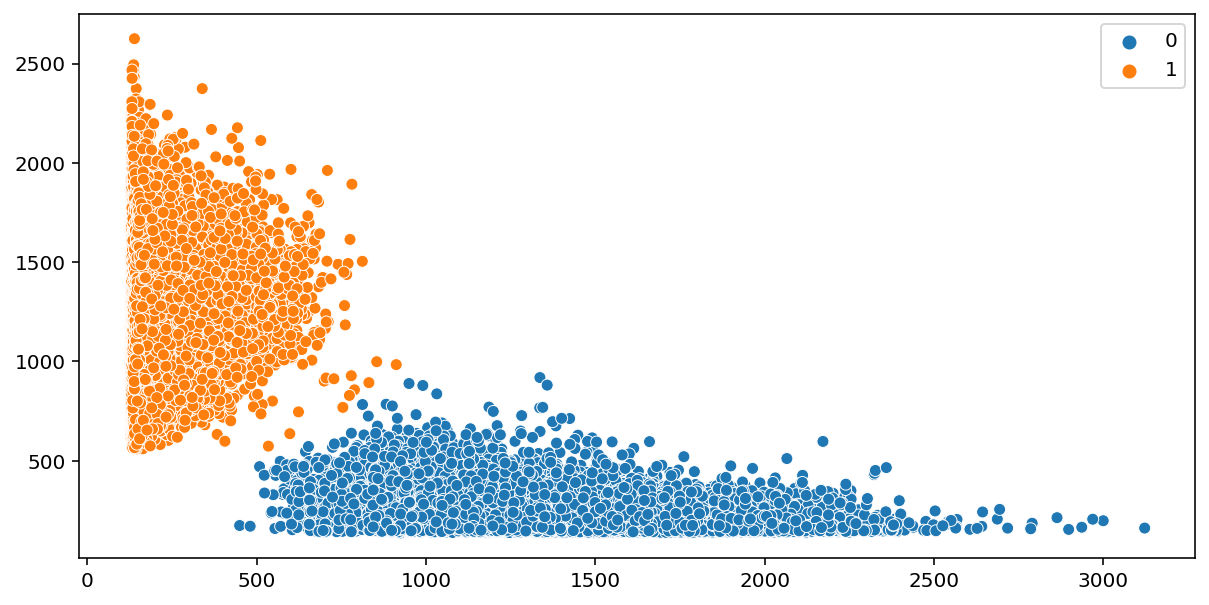

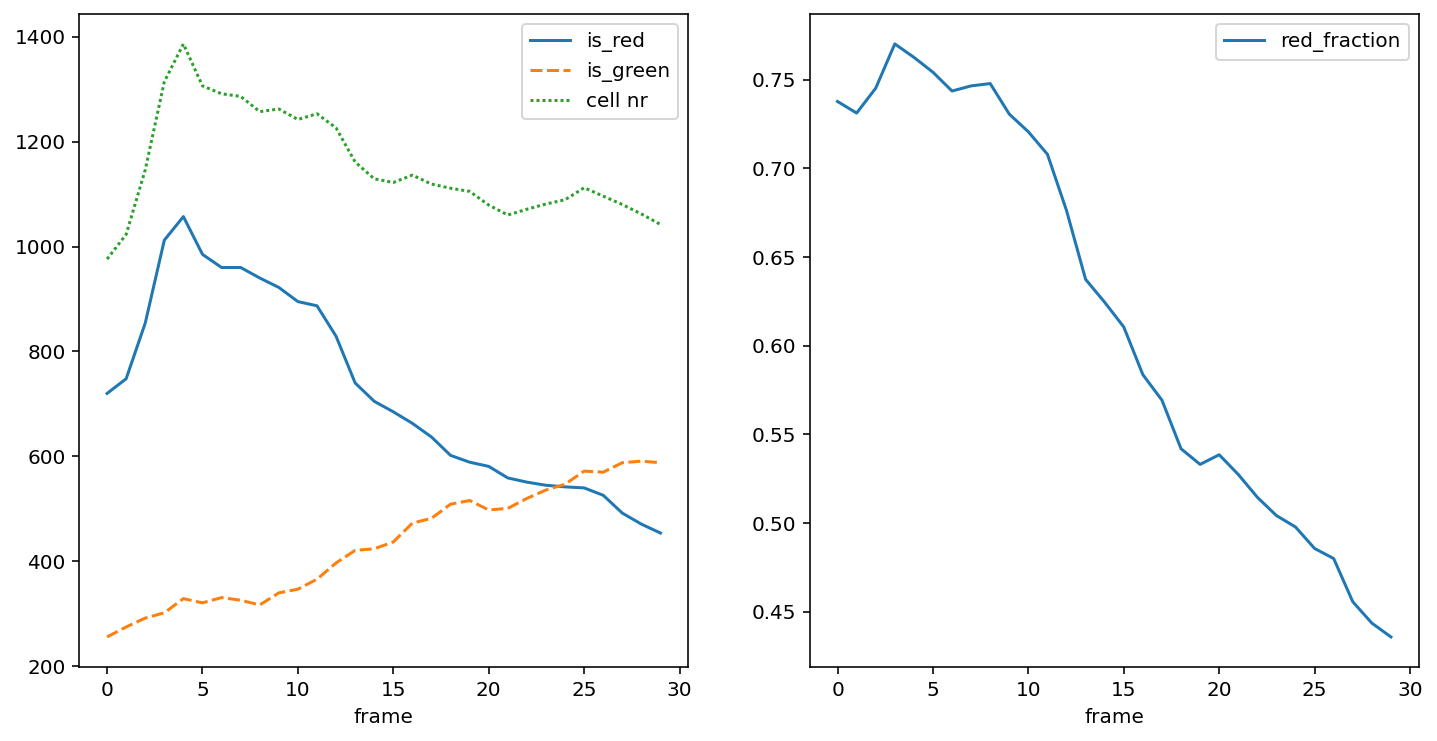

In [36]:
# %load ../Solutions/p0_classify_sol2.py
#solution 2 using K-means clustering
from sklearn.cluster import KMeans 

red = info_table_all["mean_intensity-0"]
green = info_table_all["mean_intensity-1"]
norm_fluor = pd.concat([red,green], keys=['r','g'], axis=1) 


norm_fluor_np = norm_fluor[['r','g']].to_numpy()
kmeans_fit = KMeans(n_clusters=2, random_state=0).fit(norm_fluor_np)
cell_class = kmeans_fit.labels_

sns.scatterplot(x=norm_fluor_np[:,0], y=norm_fluor_np[:,1], hue=cell_class)

norm_fluor['is_red'] = cell_class
norm_fluor['is_green'] = np.logical_not(cell_class)
norm_fluor['cell nr'] = 1
norm_fluor['frame'] = info_table_all['frame'] 

cell_type_t2 = norm_fluor.groupby('frame').sum()
cell_type_t2['red_fraction'] = cell_type_t2['is_red'] / cell_type_t2['cell nr']

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.lineplot(ax=axs[0], data=cell_type_t2[['is_red','is_green','cell nr']])
sns.lineplot(ax=axs[1], data=cell_type_t2[['red_fraction']])

## To Do (For Simon)
- Add Notebook on out-of-memory processing with Dask and with proper processing functions
- Add Notebook on fluorescent image correction (shading, background, etc)
- Add Notebook on checking classification by making new label images 
- Add Notebook on pre-processing with Python
- Check adding deconvolution to start of workflow
- Think about CSB Deep

 